In [1]:
import numpy as np
from urllib.request import urlopen
from tqdm import tqdm
import os.path
import time

In [2]:
class AlignedEmbeddingLoader(object):
    def __init__(self, lang='en'):
        self._dataurl = f"https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.{lang}.align.vec"
        cachefile = "cache_%s.npz" % lang
        if os.path.exists(cachefile):
            print("Loading cached data...", end="")
            t = time.time()
            data = np.load(cachefile)
            self.idx2token_ = list(data['idx2token'])
            self.vectors_ = data['vectors']
            print("done (%isec)" % (time.time()-t), flush=True)
        else:
            with urlopen(self._dataurl) as remote_file:
                get_decoded_line = lambda file: file.readline().decode('utf-8')
                self.n_tokens, self.n_dim = [int(n) for n in get_decoded_line(remote_file).split()]
                self.idx2token_ = list()
                self.vectors_ = np.zeros((self.n_tokens, self.n_dim), dtype=np.float32)
                for n in tqdm(range(self.vectors_.shape[0]), desc="Downloading and parsing vectors"):
                    textline = get_decoded_line(remote_file)
                    linedata = textline.split(' ')
                    self.idx2token_.append(linedata[0])
                    self.vectors_[n, :] = np.asarray(linedata[1:], dtype=np.float32)
            np.savez(cachefile, vectors=self.vectors_, idx2token=self.idx2token_)
        self.token2idx_ = {token:i for i, token in enumerate(self.idx2token_)}

loaded_embedding = AlignedEmbeddingLoader('en')

Loading cached data...done (8sec)


In [3]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

class EmbeddingAnalyzer(object):
    def __init__(self, embedding):
        self.vectors_ = embedding.vectors_
        self.token2idx_ = embedding.token2idx_
        self.idx2token_ = embedding.idx2token_

    def __len__(self):
        return len(self.vectors_)

    def __getitem__(self, tokens):
        token_list = []
        
        if type(tokens) == str:                         # e.g. tokens type: 'man'
            return self.vectors_[self.token2idx_[tokens]]
                    
        elif type(tokens) == list:                      # e.g. tokens type: ['man', 'woman']
            for t in tokens:
                for token in self.token2idx_:
                    if t == token:
                        token_list.append(self.token2idx_[token])                        
            
            for i, num in enumerate(token_list):
                token_list[i] = self.vectors_[num]
                
            return np.array(token_list)


    def __contains__(self, token):        
        if type(token) == str:
            
            if token in self.token2idx_:
                return True
            else:
                return False
            
        elif type(token) == list:
            
            for t in token:
                if t not in self.token2idx_:
                    return False
                
            return True


    def projection(self, direction, vectors):  
        return np.dot(vectors, direction) / (np.linalg.norm(vectors) * np.linalg.norm(direction))

    def simple_analogy(self, pair, query, k=5):
        from sklearn.metrics.pairwise import pairwise_distances

        x1_vec = self[pair[0]]
        x2_vec = self[pair[1]]
        y1_vec = self[query]
        V = x2_vec - x1_vec + y1_vec
        distance = pairwise_distances(V.reshape(1,len(self.vectors_[0])), self.vectors_, metric='l2').reshape(len(self))
        ids = distance.argsort()[:k+1]
        words = [self.idx2token_[idm] for idm in ids]
        best = [word for word in words if word not in (pair[0], pair[1], query)]
        return best 
        

    def similarity(self, token1, token2):
        token1 = self[token1]
        token2 = self[token2]
        return np.dot(token1, token2) / (np.linalg.norm(token1) * np.linalg.norm(token2))

    def analogies(self, analogy_direction, tokens):
        
        '''
        This part took the most time to make the data sorted as the instruction said, which I think it was unnecessarily tricky for me.
        Other than that, this assignment was very interesting and fairly easy compared to other assignment. 
        Thanks to this assignment, I'm now very interested in bias research and want to work more on related areas!
        '''
        
        from itertools import permutations
        from collections import defaultdict
    
        lst = []
        lst2 = []
        d = defaultdict(list)
        
        for x, y in permutations(tokens,2):
            if np.linalg.norm(analyzer[x]-analyzer[y]) <= 1:
                a = analyzer.projection(analogy_direction, analyzer[x]-analyzer[y])
                if np.isnan(a) == False and a > 0:
                    lst.append((x,y,a))
                                       
        for x, y, num in lst:
            d[x].append((num))
        
        res = list(zip(d, map(max, d.values())))
     
        for tup in res:
            for a in lst:
                if tup[0] == a[0] and tup[1] == a[2]:
                    lst2.append((a[0], a[1]))
                    
        return lst2

        
analyzer = EmbeddingAnalyzer(loaded_embedding)

In [4]:
assert 'man' in analyzer
assert 'woman' in analyzer
assert 'kdjfsfhgkdsjfdh' not in analyzer
assert len(analyzer) > 100000
assert type(analyzer['man']) is np.ndarray
assert np.isclose(np.sum(analyzer['man']-analyzer['man']), 0)

In [5]:
analyzer.similarity('woman', 'carpenter')

0.27906597

In [6]:
assert analyzer.similarity('cat', 'dog') >= analyzer.similarity('cat', 'cow')

In [7]:
best_matches = analyzer.simple_analogy(('man', 'woman'), 'king', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
    print(i+1, token)

assert 'queen' in analyzer.simple_analogy(('man', 'woman'), 'king', k=5)

Matches (in order of similarity):
1 queen
2 princess
3 regnant
4 princesses
5 consort


In [8]:
best_matches = analyzer.simple_analogy(('france', 'korea'), 'paris', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
    print(i+1, token)

assert 'seoul' in analyzer.simple_analogy(('france', 'korea'), 'paris', k=5)

Matches (in order of similarity):
1 seoul
2 pyongyang
3 seoul–pyongyang
4 seoul,korea
5 busan


In [9]:
# comparing adjective 

best_matches = analyzer.simple_analogy(('bad', 'worst'), 'big', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
    print(i+1, token)

assert 'biggest' in analyzer.simple_analogy(('bad', 'worst'), 'big', k=5)

Matches (in order of similarity):
1 biggest
2 snappiest
3 scariest
4 dirtiest


In [10]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json') as remote_file:
    professions = {title: {'definitional': defi, 'stereotypical': ster} for title, defi, ster in json.load(remote_file)}
print("Loaded %i professions" % len(professions))

Loaded 320 professions


In [11]:
assert type(analyzer[['man', 'woman', 'butcher']]) is np.ndarray
assert analyzer[['man', 'woman', 'butcher']].shape[0] == 3
assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['butcher']) > 0
assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['ballerina']) < 0

In [12]:
direction = analyzer['man']-analyzer['woman']
titles = [title for title in professions.keys() if title in analyzer]
projection = analyzer.projection(direction, analyzer[titles])

In [13]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/definitional_pairs.json') as remote_file:
    definitional_pairs = [(m, f) for m, f in json.load(remote_file)]
definitional_pairs

[('woman', 'man'),
 ('girl', 'boy'),
 ('she', 'he'),
 ('mother', 'father'),
 ('daughter', 'son'),
 ('gal', 'guy'),
 ('female', 'male'),
 ('her', 'his'),
 ('herself', 'himself'),
 ('Mary', 'John')]

In [14]:
direction2 = np.zeros(analyzer['man'].shape)
for female, male in definitional_pairs:
    direction2 += analyzer[male.lower()]
    direction2 -= analyzer[female.lower()]

projection2 = analyzer.projection(direction2, analyzer[titles])

C:\Users\wk789\Miniconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


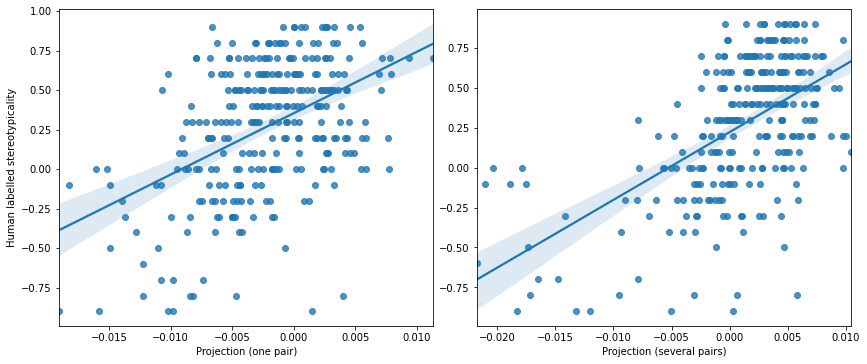

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
stereotypicality = [professions[title]['stereotypical'] for title in titles]
sns.regplot(x=projection, y=stereotypicality, ax=ax[0])
a = sns.regplot(x=projection2, y=stereotypicality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled stereotypicality")
fig.tight_layout(pad=.5)
fig.show()

C:\Users\wk789\Miniconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


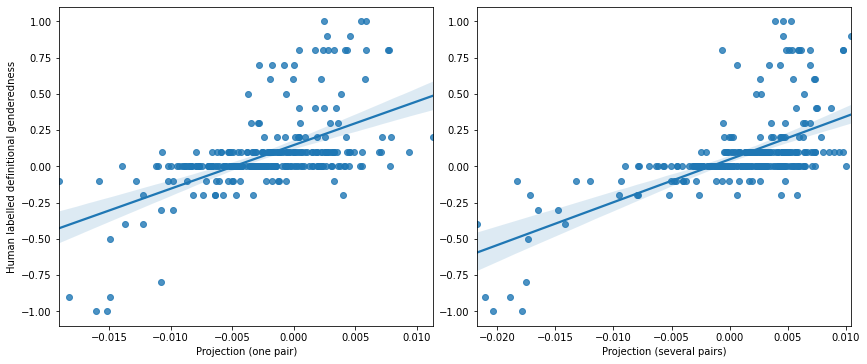

In [16]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
definitionality = [professions[title]['definitional'] for title in titles]
sns.regplot(x=projection, y=definitionality, ax=ax[0])
a = sns.regplot(x=projection2, y=definitionality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled definitional genderedness")
fig.tight_layout(pad=.5)
fig.show()

In [17]:
assert len(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == 1
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == list
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])[0]) == tuple

analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])
    

[('actor', 'actress')]

In [18]:
analyzer.analogies(analogy_direction=direction2, tokens=titles)

[('accountant', 'businesswoman'),
 ('actor', 'actress'),
 ('actress', 'waitress'),
 ('administrator', 'bureaucrat'),
 ('adventurer', 'protagonist'),
 ('advocate', 'campaigner'),
 ('aide', 'counselor'),
 ('alderman', 'solicitor'),
 ('alter_ego', 'fashion_designer'),
 ('ambassador', 'secretary'),
 ('analyst', 'columnist'),
 ('anthropologist', 'pediatrician'),
 ('archaeologist', 'anthropologist'),
 ('archbishop', 'parishioner'),
 ('architect', 'painter'),
 ('artist', 'singer'),
 ('artiste', 'performer'),
 ('assassin', 'bodyguard'),
 ('astronomer', 'archaeologist'),
 ('athlete', 'swimmer'),
 ('attorney', 'paralegal'),
 ('author', 'novelist'),
 ('ballerina', 'actress'),
 ('banker', 'businesswoman'),
 ('barber', 'hairdresser'),
 ('barrister', 'campaigner'),
 ('bartender', 'waitress'),
 ('biologist', 'pediatrician'),
 ('bishop', 'parishioner'),
 ('bookkeeper', 'waitress'),
 ('boss', 'bartender'),
 ('boxer', 'wrestler'),
 ('broadcaster', 'columnist'),
 ('broker', 'realtor'),
 ('businessman', '